In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import orjsonl
import numpy as np

In [59]:
all_values = []
datas = []
names = ["short", "truncated long", "TIPO + short", "TIPO + truncated long"]
model_order = [
    "short",
    "TIPO + short",
    "truncated long",
    "TIPO + truncated long",
]
for name, data in zip(names, orjsonl.load("./coyo-aesthetic-v25.jsonl", "rb")):
    datas.extend((name, d) for d in data)
    all_values.extend(data)
for name, data in zip(names, orjsonl.load("./gbc-aesthetic-v25.jsonl", "rb")):
    datas.extend((name, d) for d in data)
    all_values.extend(data)
all_values = np.array(all_values)
df = pd.DataFrame(datas, columns=["model", "aesthetic_score"])
print(df)
print(df["aesthetic_score"].min(), df["aesthetic_score"].max())

                       model  aesthetic_score
0                      short          6.40625
1                      short          7.09375
2                      short          6.15625
3                      short          5.65625
4                      short          4.87500
...                      ...              ...
39999  TIPO + truncated long          6.15625
40000  TIPO + truncated long          6.46875
40001  TIPO + truncated long          6.65625
40002  TIPO + truncated long          5.50000
40003  TIPO + truncated long          6.50000

[40004 rows x 2 columns]
2.453125 8.6875


In [60]:
min = df["aesthetic_score"].min()
max = df["aesthetic_score"].max()
std = df["aesthetic_score"].std()
mean = df["aesthetic_score"].mean()

# df["aesthetic_score"] = (df["aesthetic_score"] - mean) / std

In [61]:
y_scale = 1.0
box_scale = 0.7

C:\Users\apoll\AppData\Local\Temp\ipykernel_88100\839628353.py:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df_sorted.groupby("model")["aesthetic_score"].quantile(
C:\Users\apoll\AppData\Local\Temp\ipykernel_88100\839628353.py:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_sorted.groupby("model")["aesthetic_score"].mean()
C:\Users\apoll\AppData\Local\Temp\ipykernel_88100\839628353.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

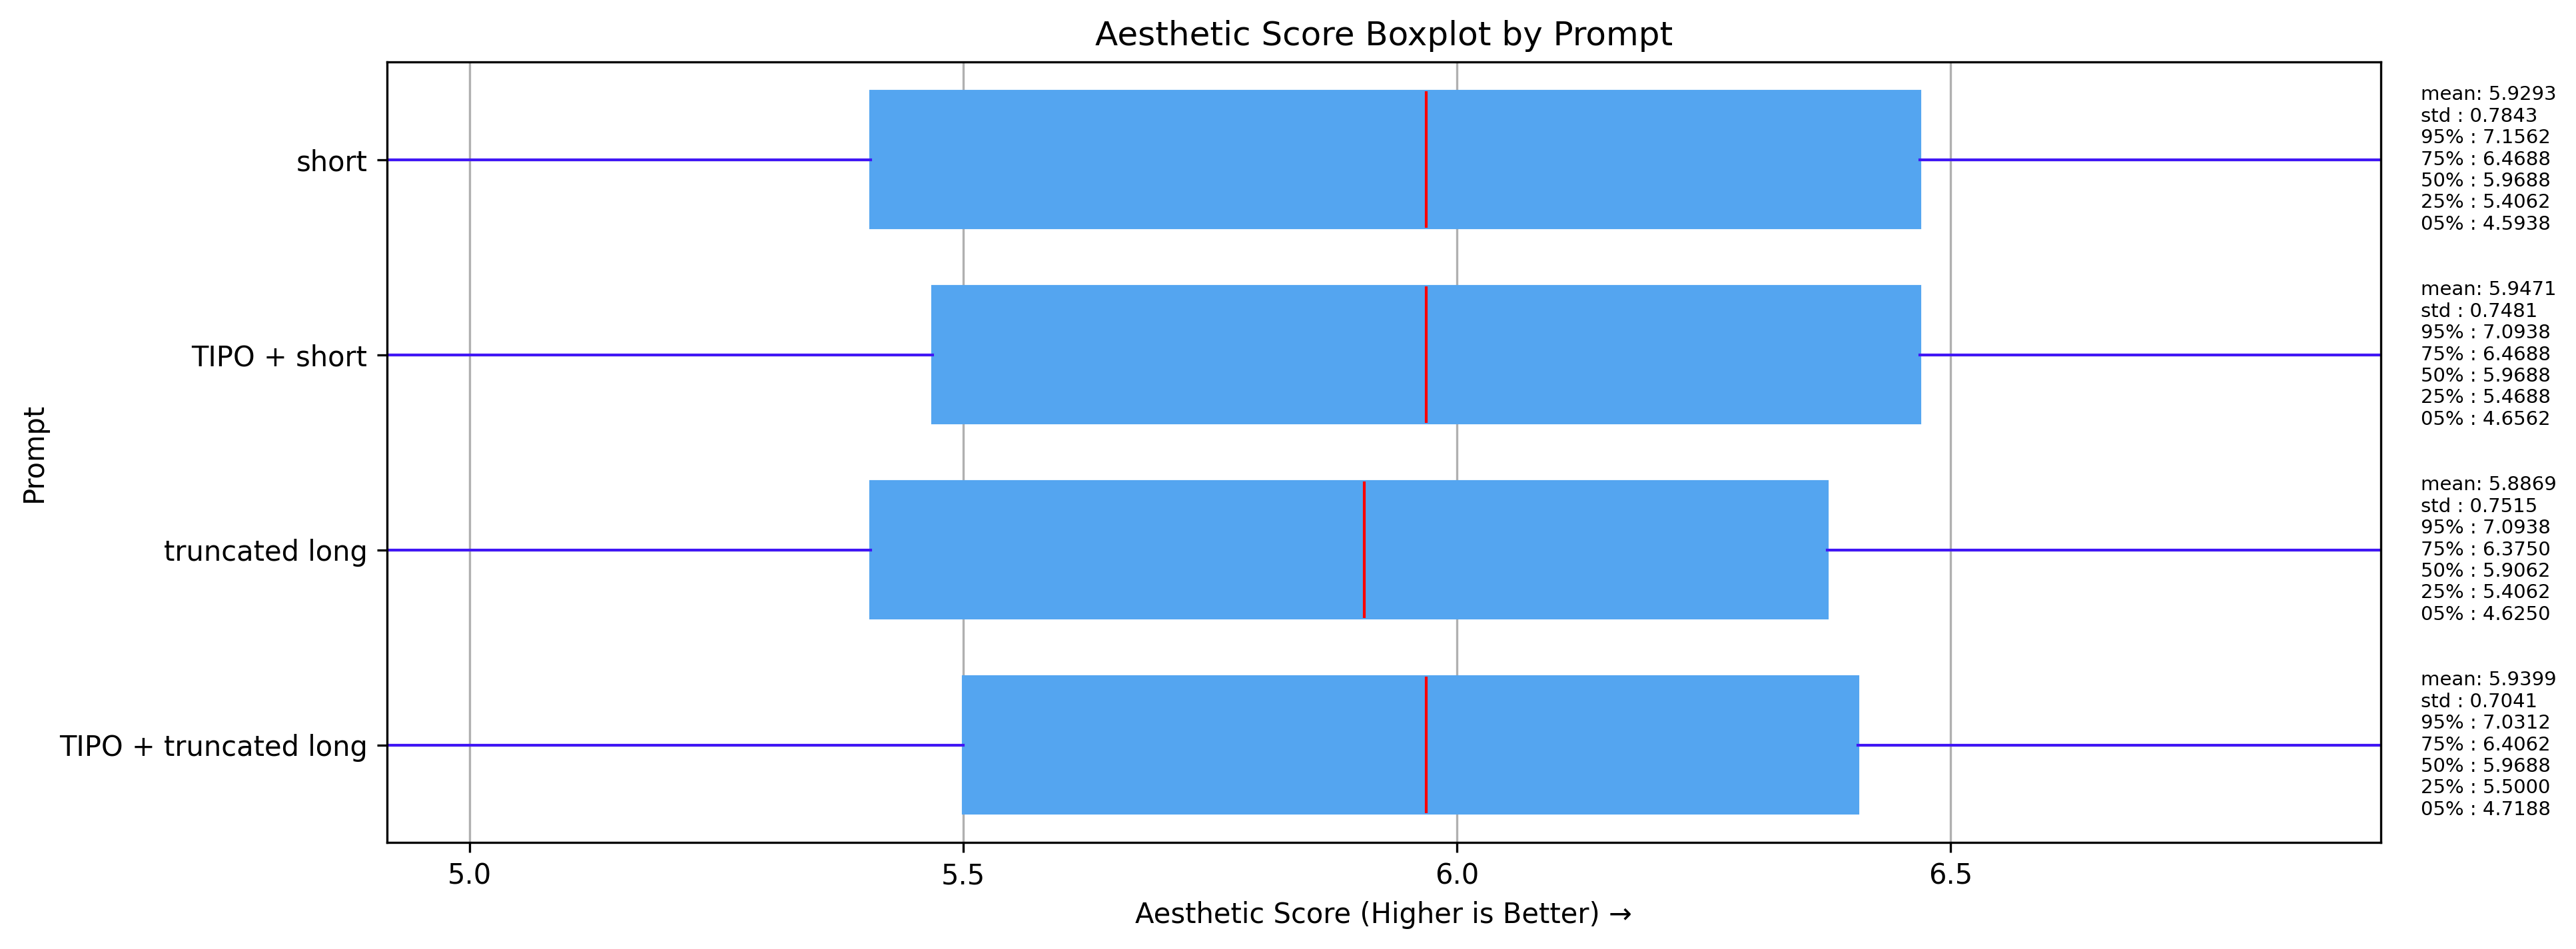


Quantiles for each model:
model                      
TIPO + truncated long  0.05    4.71875
                       0.25    5.50000
                       0.50    5.96875
                       0.75    6.40625
                       0.95    7.03125
truncated long         0.05    4.62500
                       0.25    5.40625
                       0.50    5.90625
                       0.75    6.37500
                       0.95    7.09375
TIPO + short           0.05    4.65625
                       0.25    5.46875
                       0.50    5.96875
                       0.75    6.46875
                       0.95    7.09375
short                  0.05    4.59375
                       0.25    5.40625
                       0.50    5.96875
                       0.75    6.46875
                       0.95    7.15625
Name: aesthetic_score, dtype: float64


In [62]:
# Calculate statistics for sorting
df_stats = (
    df.groupby("model")
    .agg({"aesthetic_score": ["mean", lambda x: x.mean()]})
    .reset_index()
)
df_stats.columns = ["model", "mean", "aesthetic_score"]

# Choose sorting method (uncomment the desired method)
# df_stats_sorted = df_stats.sort_values('median', ascending=False)
df_stats_sorted = df_stats.sort_values("mean", ascending=False)

# Sort the original dataframe based on the stats
df_sorted = df.set_index("model").loc[model_order].reset_index()
# print(df_stats)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(13, 5), dpi=300)

df_sorted["model"] = pd.Categorical(
    df_sorted["model"],
    categories=reversed(list(df_sorted["model"].unique())),
    ordered=True,
)
positions = [i * y_scale for i in range(len(model_order))]
# Create the horizontal boxplot using the sorted data
boxplot = df_sorted.boxplot(
    column="aesthetic_score",
    by="model",
    vert=False,
    ax=ax,
    patch_artist=True,
    medianprops={"color": "red"},
    showfliers=False,
    color={
        "boxes": "#54A5F0",
        "whiskers": "#4016F5",
        "medians": "red",
        "caps": "black",
    },
    positions=positions,
    widths=[box_scale] * len(model_order),
)

# Customize the plot
ax.set_title("Aesthetic Score Boxplot by Prompt")
ax.set_ylabel("Prompt")
ax.set_xlabel("Aesthetic Score (Higher is Better) →")

# Remove the automatically generated suptitle
plt.suptitle("")

# Adjust the y-axis tick labels
plt.yticks(rotation=0)

# Adjust the data range and tick marks
min_score = df["aesthetic_score"].min()
max_score = df["aesthetic_score"].max()

# Calculate and add quantile information
quantiles = df_sorted.groupby("model")["aesthetic_score"].quantile(
    [0.05, 0.25, 0.5, 0.75, 0.95]
)
reverse_map = {
    v1: v2
    for v1, v2 in zip(
        df_sorted["model"].unique(), reversed(df_sorted["model"].unique())
    )
}
ax.set_xlim(mean - 1.35 * std, mean + 1.35 * std)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))

means = df_sorted.groupby("model")["aesthetic_score"].mean()
std = df_sorted.groupby("model")["aesthetic_score"].std()

# print(quantiles)
for i, model in enumerate(df_sorted["model"].unique()):
    model = reverse_map[model]
    quantile_text = (
        f"mean: {means.loc[model]:.4f}\n"
        f"std : {std.loc[model]:.4f}\n"
        f"95% : {quantiles.loc[model, 0.95]:.4f}\n"
        f"75% : {quantiles.loc[model, 0.75]:.4f}\n"
        f"50% : {quantiles.loc[model, 0.50]:.4f}\n"
        f"25% : {quantiles.loc[model, 0.25]:.4f}\n"
        f"05% : {quantiles.loc[model, 0.05]:.4f}"
    )
    ax.annotate(
        quantile_text,
        xy=(1.02, i * y_scale),
        xycoords=("axes fraction", "data"),
        va="center",
        ha="left",
        fontsize=7,
    )

# Display the plot
plt.tight_layout()
plt.show()

# Log quantile information
print("\nQuantiles for each model:")
print(quantiles)

C:\Users\apoll\AppData\Local\Temp\ipykernel_88100\3173393966.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantiles = df_sorted.groupby("model")["aesthetic_score"].quantile(
C:\Users\apoll\AppData\Local\Temp\ipykernel_88100\3173393966.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = df_sorted.groupby("model")["aesthetic_score"].mean()
C:\Users\apoll\AppData\Local\Temp\ipykernel_88100\3173393966.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt 

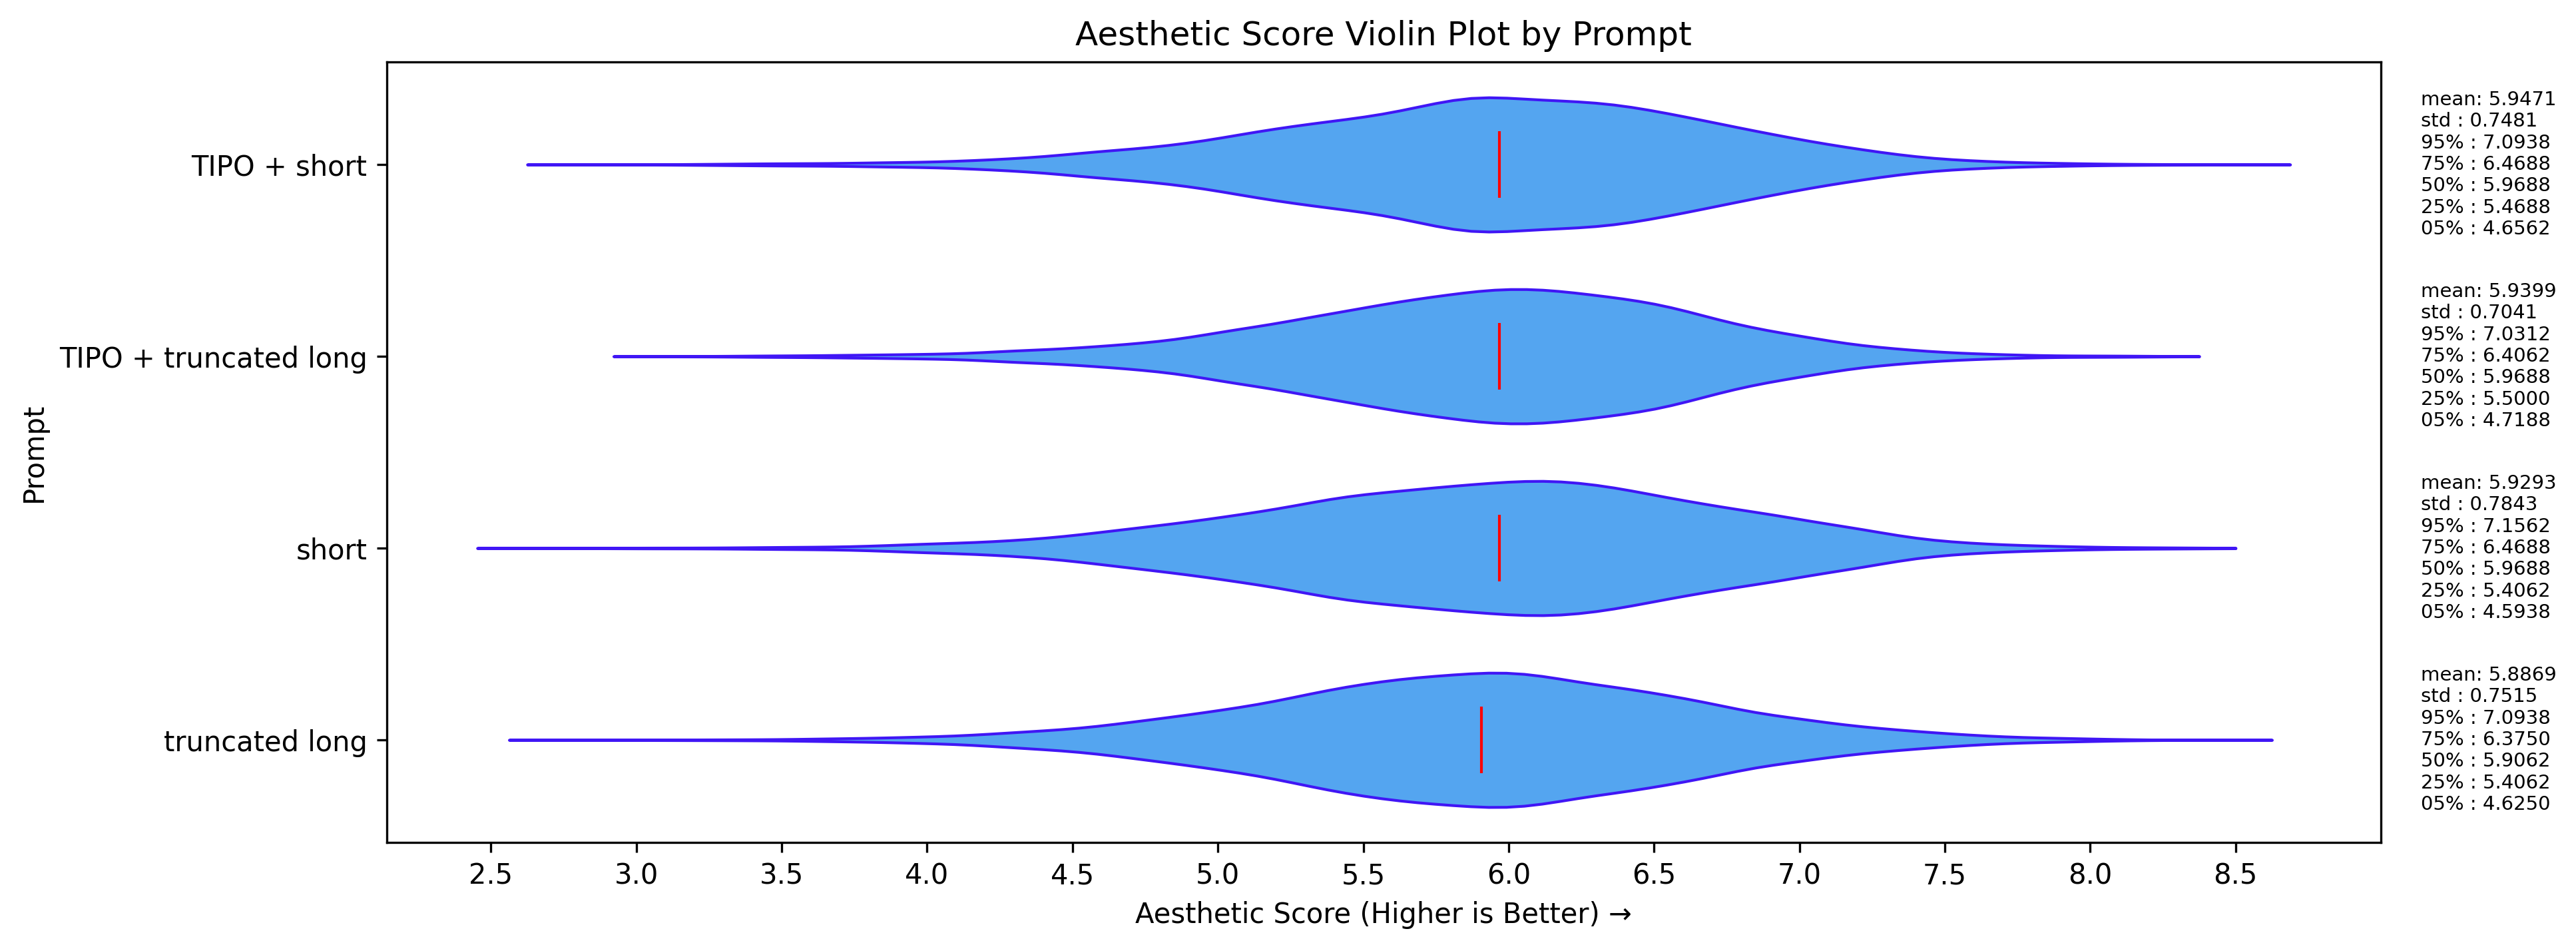


Quantiles for each model:
model                      
truncated long         0.05    4.62500
                       0.25    5.40625
                       0.50    5.90625
                       0.75    6.37500
                       0.95    7.09375
short                  0.05    4.59375
                       0.25    5.40625
                       0.50    5.96875
                       0.75    6.46875
                       0.95    7.15625
TIPO + truncated long  0.05    4.71875
                       0.25    5.50000
                       0.50    5.96875
                       0.75    6.40625
                       0.95    7.03125
TIPO + short           0.05    4.65625
                       0.25    5.46875
                       0.50    5.96875
                       0.75    6.46875
                       0.95    7.09375
Name: aesthetic_score, dtype: float64


In [63]:
# Calculate statistics for sorting
df_stats = (
    df.groupby("model")
    .agg({"aesthetic_score": ["mean", lambda x: x.mean()]})
    .reset_index()
)
df_stats.columns = ["model", "mean", "aesthetic_score"]

# Choose sorting method (uncomment the desired method)
# df_stats_sorted = df_stats.sort_values('median', ascending=False)
df_stats_sorted = df_stats.sort_values("mean", ascending=False)

# Get the model order
model_order = df_stats_sorted["model"]

# Sort the original dataframe based on the stats
df_sorted = df.set_index("model").loc[model_order].reset_index()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(13, 5), dpi=300)

# Reverse the model categories
df_sorted["model"] = pd.Categorical(
    df_sorted["model"],
    categories=reversed(list(df_sorted["model"].unique())),
    ordered=True,
)

# Define y-scale and positions
y_scale = 1  # Adjust as needed
box_scale = 0.7  # Adjust as needed
positions = [i * y_scale for i in range(len(model_order))]

# Prepare data for violin plot
data = [
    df_sorted[df_sorted["model"] == model]["aesthetic_score"].values
    for model in df_sorted["model"].cat.categories
]

# Create the horizontal violin plot using the sorted data
violin = ax.violinplot(
    dataset=data,
    positions=positions,
    vert=False,
    widths=[box_scale] * len(model_order),
    showmeans=False,
    showextrema=False,
    showmedians=True,
    bw_method=None,
)

# Customize the violin plots
for pc in violin["bodies"]:
    pc.set_facecolor("#54A5F0")  # Same color as 'boxes' in boxplot
    pc.set_edgecolor("#4016F5")  # Same color as 'whiskers' in boxplot
    pc.set_alpha(1)

# Customize the median lines
violin["cmedians"].set_color("red")
violin["cmedians"].set_linewidth(1)

# Customize the plot
ax.set_title("Aesthetic Score Violin Plot by Prompt")
ax.set_ylabel("Prompt")
ax.set_xlabel("Aesthetic Score (Higher is Better) →")

# Set y-ticks
ax.set_yticks(positions)
ax.set_yticklabels(df_sorted["model"].cat.categories)

# Remove the automatically generated suptitle
plt.suptitle("")

# Adjust the x-limits and x-ticks
mean = df_sorted["aesthetic_score"].mean()
std = df_sorted["aesthetic_score"].std()
# ax.set_xlim(mean - 1.35 * std, mean + 1.35 * std)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))

# Calculate and add quantile information
quantiles = df_sorted.groupby("model")["aesthetic_score"].quantile(
    [0.05, 0.25, 0.5, 0.75, 0.95]
)
means = df_sorted.groupby("model")["aesthetic_score"].mean()
stds = df_sorted.groupby("model")["aesthetic_score"].std()

# Annotate the plot with quantile information
for i, model in enumerate(df_sorted["model"].cat.categories):
    quantile_text = (
        f"mean: {means.loc[model]:.4f}\n"
        f"std : {stds.loc[model]:.4f}\n"
        f"95% : {quantiles.loc[model, 0.95]:.4f}\n"
        f"75% : {quantiles.loc[model, 0.75]:.4f}\n"
        f"50% : {quantiles.loc[model, 0.50]:.4f}\n"
        f"25% : {quantiles.loc[model, 0.25]:.4f}\n"
        f"05% : {quantiles.loc[model, 0.05]:.4f}"
    )
    ax.annotate(
        quantile_text,
        xy=(1.02, positions[i]),
        xycoords=("axes fraction", "data"),
        va="center",
        ha="left",
        fontsize=7,
    )

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Log quantile information
print("\nQuantiles for each model:")
print(quantiles)

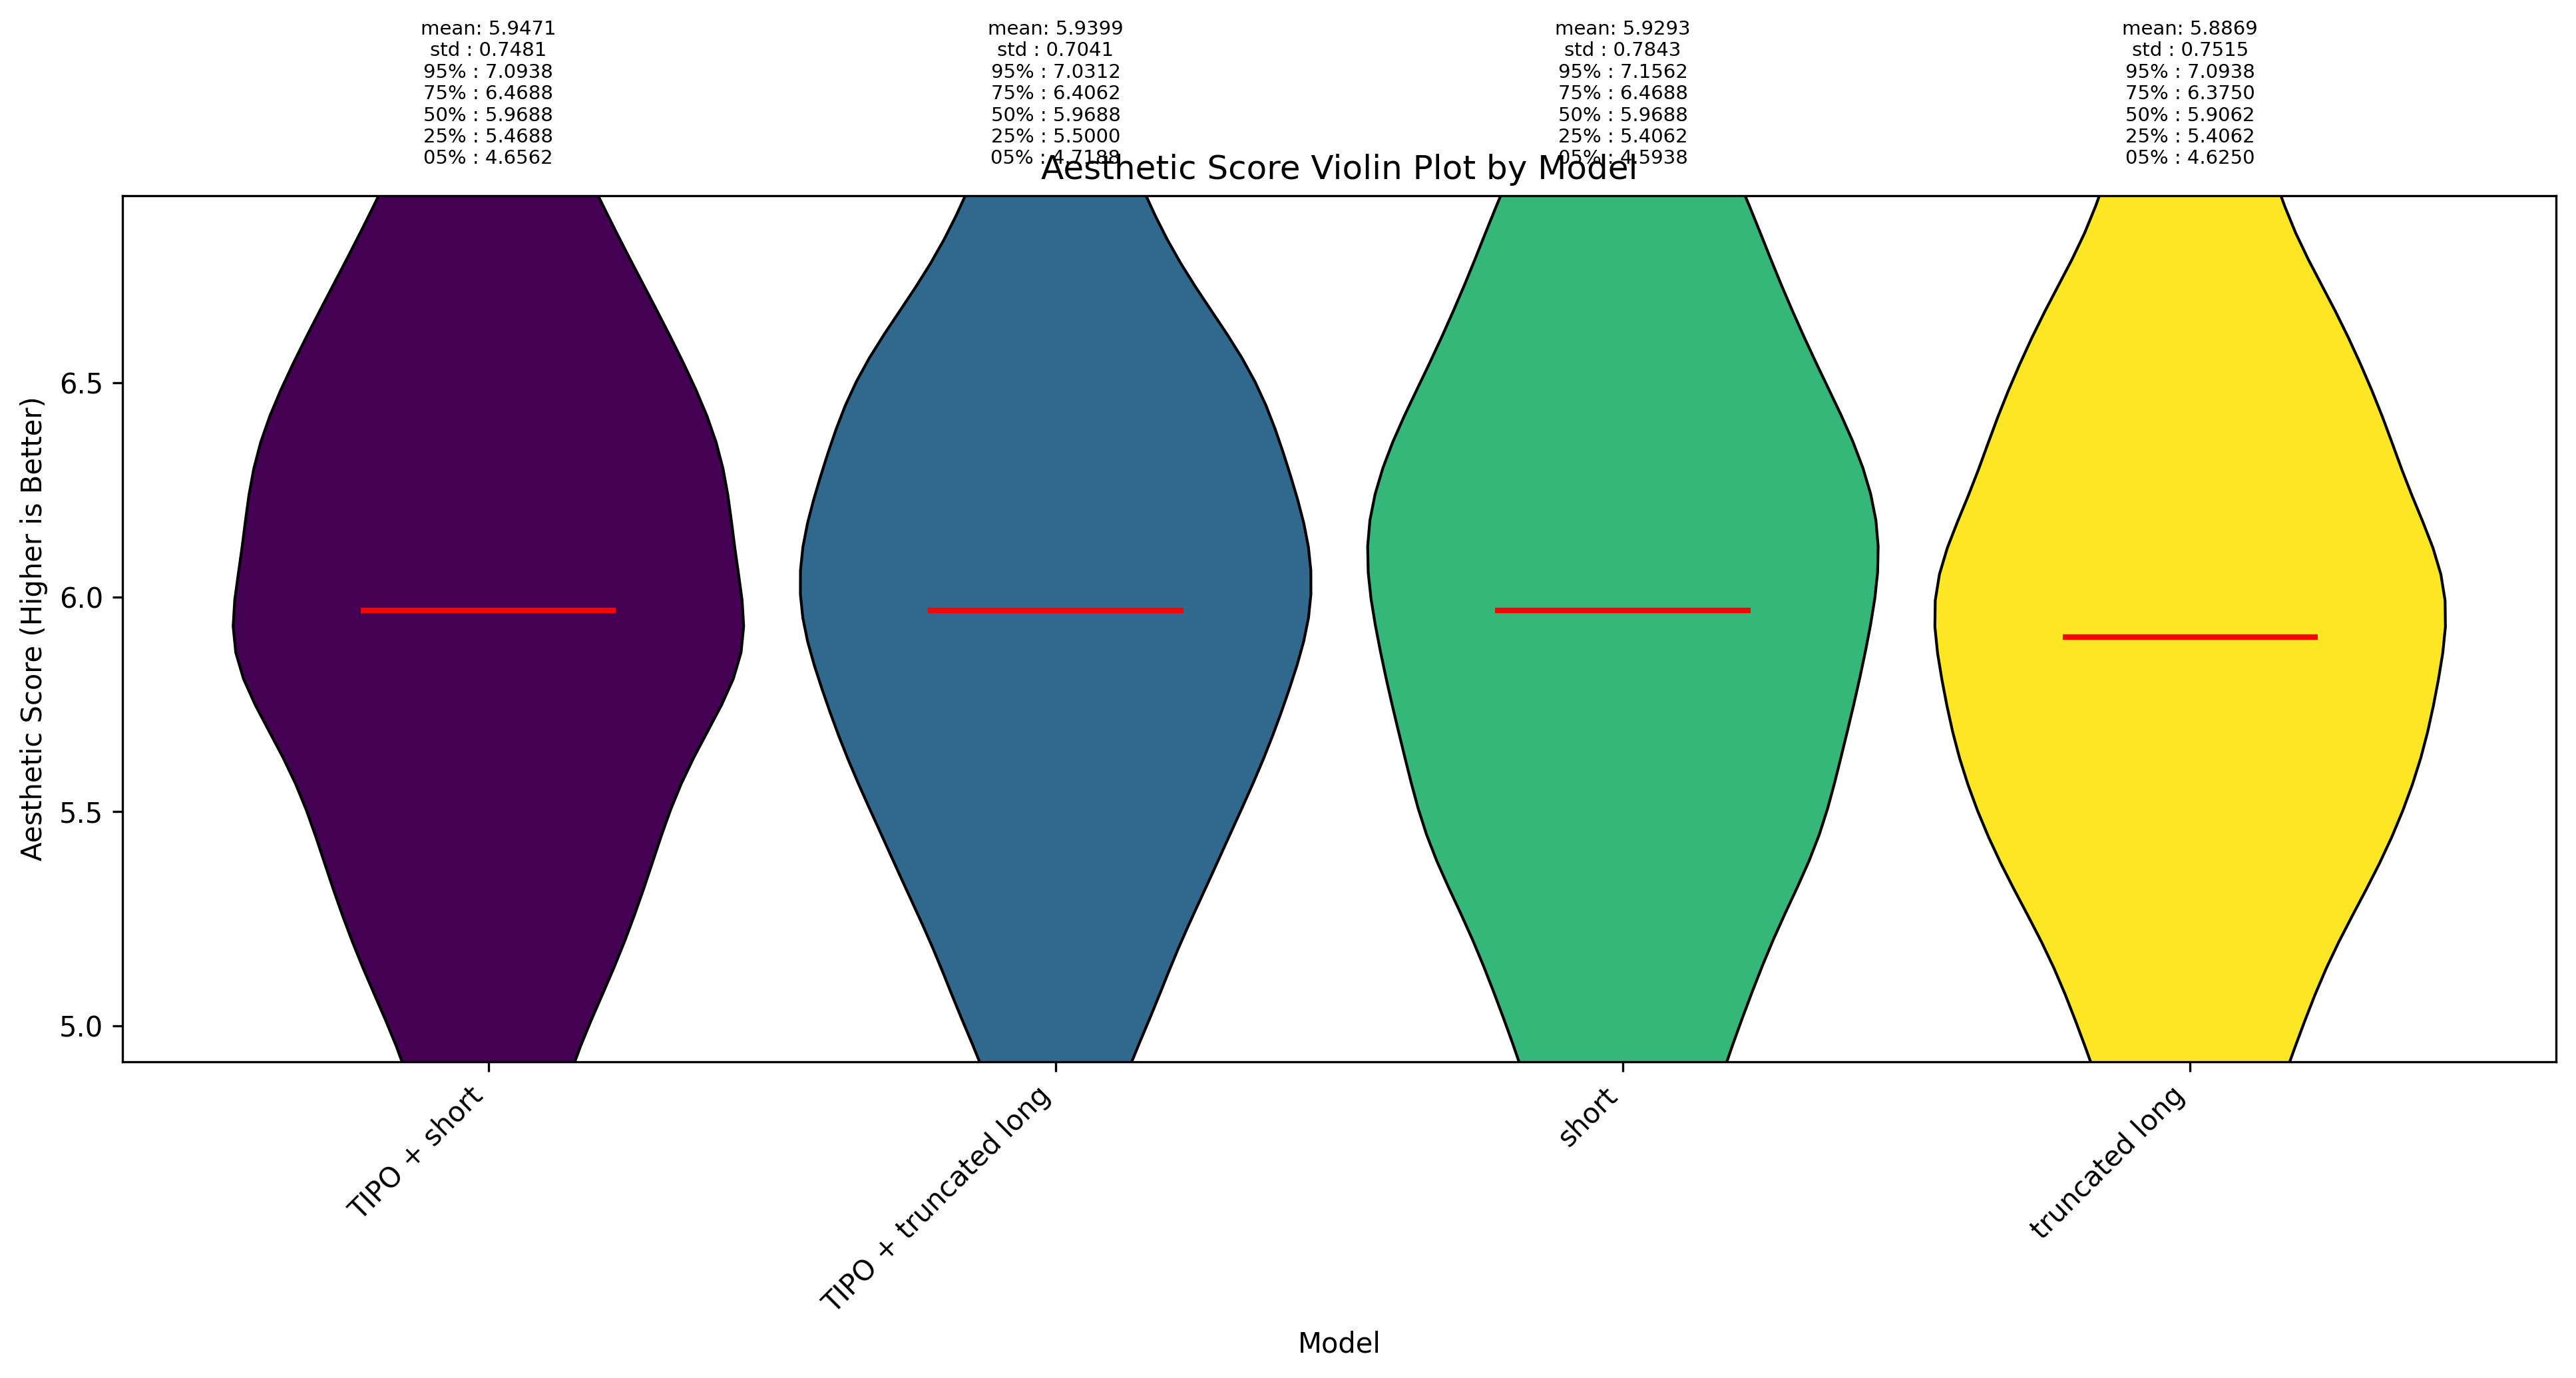


Quantiles for each model:
model                      
TIPO + short           0.05    4.65625
                       0.25    5.46875
                       0.50    5.96875
                       0.75    6.46875
                       0.95    7.09375
TIPO + truncated long  0.05    4.71875
                       0.25    5.50000
                       0.50    5.96875
                       0.75    6.40625
                       0.95    7.03125
short                  0.05    4.59375
                       0.25    5.40625
                       0.50    5.96875
                       0.75    6.46875
                       0.95    7.15625
truncated long         0.05    4.62500
                       0.25    5.40625
                       0.50    5.90625
                       0.75    6.37500
                       0.95    7.09375
Name: aesthetic_score, dtype: float64


In [64]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Calculate statistics for sorting
df_stats = (
    df.groupby("model")
    .agg({"aesthetic_score": ["mean", lambda x: x.mean()]})
    .reset_index()
)
df_stats.columns = ["model", "mean", "aesthetic_score"]

# Choose sorting method (uncomment the desired method)
# df_stats_sorted = df_stats.sort_values('median', ascending=False)
df_stats_sorted = df_stats.sort_values("mean", ascending=False)

# Get the model order
model_order = df_stats_sorted["model"].tolist()

# Sort the original dataframe based on the stats
df_sorted = df.set_index("model").loc[model_order].reset_index()

# Create a figure and axes
fig, ax = plt.subplots(figsize=(13, 7), dpi=300)

# Define x-scale and positions
x_scale = 1  # Adjust as needed
positions = [i * x_scale for i in range(len(model_order))]

# Prepare data for violin plot
data = [
    df_sorted[df_sorted["model"] == model]["aesthetic_score"].values
    for model in model_order
]

# Generate a color map for the models
colors = cm.viridis(np.linspace(0, 1, len(model_order)))

# Create the vertical violin plot using the sorted data
violin = ax.violinplot(
    dataset=data,
    positions=positions,
    vert=True,
    widths=0.9,  # Adjust as needed
    showmeans=False,
    showextrema=False,
    showmedians=True,
    bw_method=None,
)

# Customize the violin plots with different colors
for i, pc in enumerate(violin["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor("black")
    pc.set_alpha(1)

# Customize the median lines
violin["cmedians"].set_color("red")
violin["cmedians"].set_linewidth(2)

# Customize the plot
ax.set_title("Aesthetic Score Violin Plot by Model")
ax.set_xlabel("Model")
ax.set_ylabel("Aesthetic Score (Higher is Better)")

# Set x-ticks
ax.set_xticks(positions)
ax.set_xticklabels(model_order, rotation=45, ha="right")

# Adjust the y-limits and y-ticks
mean = df_sorted["aesthetic_score"].mean()
std = df_sorted["aesthetic_score"].std()
ax.set_ylim(mean - 1.35 * std, mean + 1.35 * std)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

# Calculate and add quantile information
quantiles = df_sorted.groupby("model")["aesthetic_score"].quantile(
    [0.05, 0.25, 0.5, 0.75, 0.95]
)
means = df_sorted.groupby("model")["aesthetic_score"].mean()
stds = df_sorted.groupby("model")["aesthetic_score"].std()

# Annotate the plot with quantile information
for i, model in enumerate(model_order):
    quantile_text = (
        f"mean: {means.loc[model]:.4f}\n"
        f"std : {stds.loc[model]:.4f}\n"
        f"95% : {quantiles.loc[model, 0.95]:.4f}\n"
        f"75% : {quantiles.loc[model, 0.75]:.4f}\n"
        f"50% : {quantiles.loc[model, 0.50]:.4f}\n"
        f"25% : {quantiles.loc[model, 0.25]:.4f}\n"
        f"05% : {quantiles.loc[model, 0.05]:.4f}"
    )
    ax.annotate(
        quantile_text,
        xy=(positions[i], ax.get_ylim()[1]),
        xytext=(0, 10),
        textcoords="offset points",
        va="bottom",
        ha="center",
        fontsize=7,
        rotation=0,
    )

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Log quantile information
print("\nQuantiles for each model:")
print(quantiles)